In [5]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

from tensorflow.keras import backend as K
import time

# CHAOS dataset

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 128
EPOCHS = 65
BATCH = 8



def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_x_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/train/HU_CT_Images"
train_x_file_names = os.listdir(train_x_folder_path)
train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# train_x

train_y_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/train/Liver_Masks"
train_y_file_names = os.listdir(train_y_folder_path)
train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# train_y




valid_x_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/val/HU_CT_Images"
valid_x_file_names = os.listdir(valid_x_folder_path)
valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# valid_x

valid_y_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/val/Liver_Masks"
valid_y_file_names = os.listdir(valid_y_folder_path)
valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# valid_y


test_x_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/test/HU_CT_Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/chaos-tr-val-te/CHAOS_tr_val_te/test/Liver_Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y


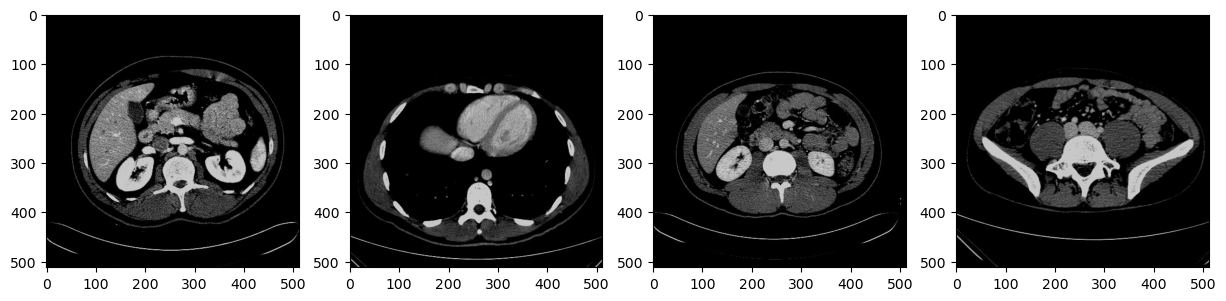

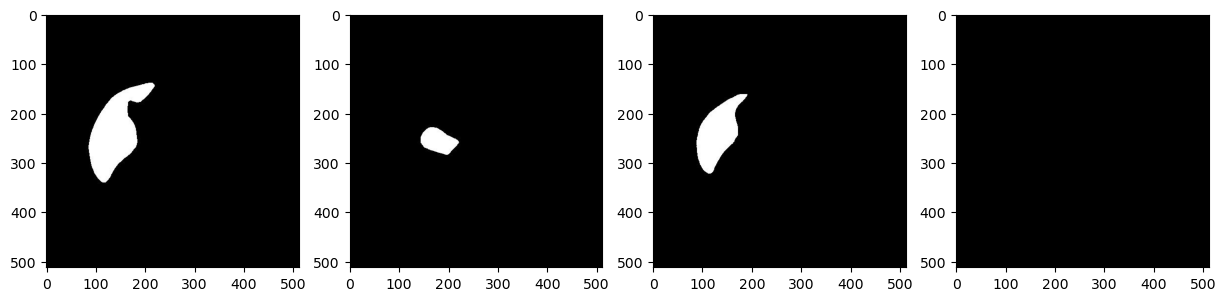

In [3]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [4]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [5]:
from keras.models import load_model

print("For Vanilla U-Net")
model = load_model('/kaggle/input/chaosmodels/UNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

For Vanilla U-Net
Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                    

[0.02030591107904911,
 0.9796940684318542,
 0.9771789908409119,
 0.9861288070678711,
 0.9816054105758667,
 0.9831783771514893,
 0.9602743983268738,
 0.03972546383738518,
 -0.005865949671715498]

In [6]:
print("For Attention U-Net")
model = load_model('/kaggle/input/chaosmodels/AttentionUNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For Attention U-Net
Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256               

[0.019132914021611214,
 0.9808671474456787,
 0.9824338555335999,
 0.9838182926177979,
 0.9831074476242065,
 0.9832677841186523,
 0.962505578994751,
 0.0374947190284729,
 0.0013653491623699665]

In [7]:
print("For V-Net")
model = load_model('/kaggle/input/chaosmodels/VNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For V-Net
Model: "vnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vnet_input_conv_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 vnet_input_conv_0_bn (BatchNor  (None, 128, 128, 64  256        ['vnet_input_conv_0[0][0]']      
 malization)                    )                                              

[0.019984662532806396,
 0.9800153374671936,
 0.9807285666465759,
 0.9821826219558716,
 0.9814332127571106,
 0.9832397103309631,
 0.9608726501464844,
 0.039127469062805176,
 0.0014771298738196492]

In [8]:
print("For U-Net-3+")
model = load_model('/kaggle/input/chaosmodels/UNet3plus2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U-Net-3+
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 unet3plus_down0_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 unet3plus_down0_0_bn (BatchNor  (None, 128, 128, 64  256        ['unet3plus_down0_0[0][0]']      
 malization)                    )                                                

[0.08270978927612305,
 0.9172901511192322,
 0.9577222466468811,
 0.883587121963501,
 0.9180419445037842,
 0.9763861894607544,
 0.8495051264762878,
 0.15049487352371216,
 0.09461113810539246]

In [11]:
print("For R2-U-Net")
model = load_model('/kaggle/input/chaosmodels/R2Unet_Chaos.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For R2-U-Net
Model: "r2unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r2unet_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 r2unet_down0_conv (Conv2D)     (None, 128, 128, 64  256         ['r2unet_input[0][0]']           
                                )                                                                 
                                                                                                  
 r2unet_down0_conv0 (Conv2D)    (None, 128, 128, 64  36928       ['r2unet_down0_conv[0][0]']      
                                )                                         

[0.025607414543628693,
 0.9743924736976624,
 0.9757707118988037,
 0.9749264121055603,
 0.9753013253211975,
 0.9828624725341797,
 0.9501702189445496,
 0.04982975497841835,
 0.0030466478783637285]

In [12]:
print("For U2-Net")
model = load_model('/kaggle/input/chaosmodels/u2net_2d.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U2-Net
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 u2net_in_in_0 (Conv2D)         (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 u2net_in_in_0_bn (BatchNormali  (None, 128, 128, 64  256        ['u2net_in_in_0[0][0]']          
 zation)                        )                                                  

[0.0337713398039341,
 0.966228723526001,
 0.9786808490753174,
 0.9822724461555481,
 0.9804563522338867,
 0.9832701086997986,
 0.9347541332244873,
 0.06524568796157837,
 -0.0023130725603550673]

In [10]:
print("For U-Net++")
model = load_model('/kaggle/input/chaosmodels/UNet++.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U-Net++
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 128, 128, 32  896         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 128, 128, 32  0           ['conv11_1[0][0]']               
                                )                                               

[0.04609193280339241,
 0.9766138792037964,
 0.9742875695228577,
 0.9792543053627014,
 0.9767395853996277,
 0.9830966591835022,
 0.9543668031692505,
 0.04563320800662041,
 -0.002894062316045165]

# For 3DIRCADb dataset

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 128
EPOCHS = 65
BATCH = 8



def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_x_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/train/CT_Images_HU_Clipped"
train_x_file_names = os.listdir(train_x_folder_path)
train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# train_x

train_y_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/train/liver_masks"
train_y_file_names = os.listdir(train_y_folder_path)
train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# train_y




valid_x_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/val/CT_Images_HU_Clipped"
valid_x_file_names = os.listdir(valid_x_folder_path)
valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# valid_x

valid_y_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/val/liver_masks"
valid_y_file_names = os.listdir(valid_y_folder_path)
valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# valid_y


test_x_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/CT_Images_HU_Clipped"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/liver_masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y


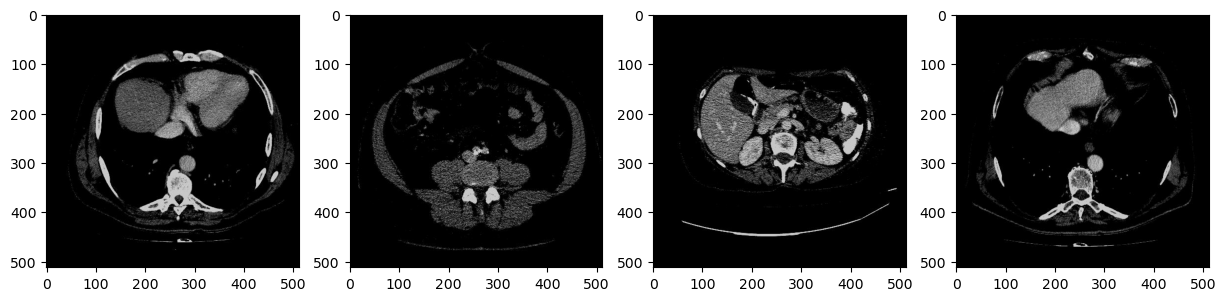

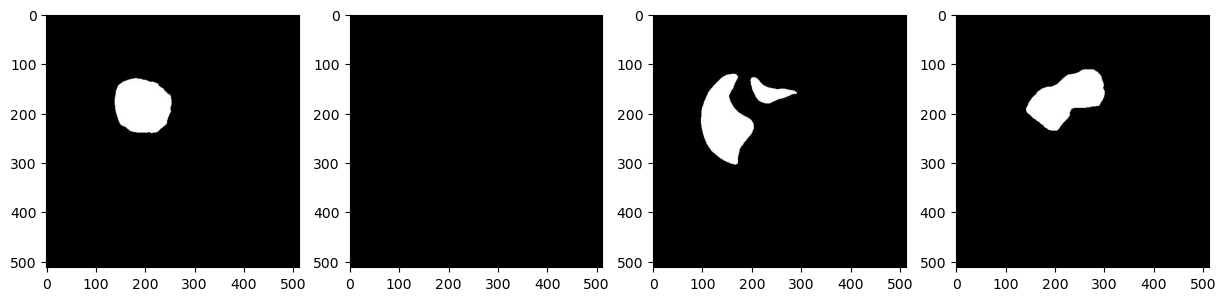

In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [12]:
from keras.models import load_model

print("For Vanilla U-Net")
model = load_model('/kaggle/input/3dircadbmodels/UNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

For Vanilla U-Net
Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                    

[0.028460301458835602,
 0.9715055227279663,
 0.9684634208679199,
 0.9802284836769104,
 0.9742671251296997,
 0.9770941138267517,
 0.944675624370575,
 0.05532434210181236,
 -0.007881262339651585]

In [14]:
print("For Attention U-Net")
model = load_model('/kaggle/input/3dircadbmodels/AttentionUNet.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For Attention U-Net
Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256               

[0.026341767981648445,
 0.9736303687095642,
 0.969386875629425,
 0.9824550747871399,
 0.975841224193573,
 0.9771046042442322,
 0.948688805103302,
 0.05131111666560173,
 -0.011287512257695198]

In [15]:
print("For V-Net")
model = load_model('/kaggle/input/3dircadbmodels/VNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For V-Net
Model: "vnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vnet_input_conv_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 vnet_input_conv_0_bn (BatchNor  (None, 128, 128, 64  256        ['vnet_input_conv_0[0][0]']      
 malization)                    )                                              

[0.026393089443445206,
 0.9735755324363708,
 0.9660063982009888,
 0.9833237528800964,
 0.9745420217514038,
 0.9771289229393005,
 0.9486066699028015,
 0.05139322578907013,
 -0.016870368272066116]

In [16]:
print("For U-Net-3+")
model = load_model('/kaggle/input/3dircadbmodels/UNet3plus2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U-Net-3+
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 unet3plus_down0_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 unet3plus_down0_0_bn (BatchNor  (None, 128, 128, 64  256        ['unet3plus_down0_0[0][0]']      
 malization)                    )                                                

[0.027443580329418182,
 0.9725241661071777,
 0.9693917036056519,
 0.9778775572776794,
 0.9735729694366455,
 0.9770873188972473,
 0.9466193914413452,
 0.05338064953684807,
 -0.008187785744667053]

In [17]:
print("For R2-U-Net")
model = load_model('/kaggle/input/3dircadbmodels/R2Unet_3dircadb.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For R2-U-Net
Model: "r2unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r2unet_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 r2unet_down0_conv (Conv2D)     (None, 128, 128, 64  256         ['r2unet_input[0][0]']           
                                )                                                                 
                                                                                                  
 r2unet_down0_conv0 (Conv2D)    (None, 128, 128, 64  36928       ['r2unet_down0_conv[0][0]']      
                                )                                         

[0.033392515033483505,
 0.9665889739990234,
 0.957990825176239,
 0.9773083329200745,
 0.9674280881881714,
 0.9767510890960693,
 0.9355103373527527,
 0.06448975205421448,
 -0.019094424322247505]

In [19]:
print("For U2-Net")
model = load_model('/kaggle/input/3dircadbmodels/u2net_2d_3dircadb.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U2-Net
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 u2net_in_in_0 (Conv2D)         (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 u2net_in_in_0_bn (BatchNormali  (None, 128, 128, 64  256        ['u2net_in_in_0[0][0]']          
 zation)                        )                                                  

[0.04277583956718445,
 0.9572052359580994,
 0.9763093590736389,
 0.9810798764228821,
 0.9786735773086548,
 0.9772575497627258,
 0.9181551933288574,
 0.08184486627578735,
 -0.004192794673144817]

In [18]:
print("For U-Net++")
model = load_model('/kaggle/input/3dircadbmodels/UNet++_3dircadb.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

For U-Net++
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 128, 128, 32  896         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 128, 128, 32  0           ['conv11_1[0][0]']               
                                )                                               

[0.09715022146701813,
 0.9690459370613098,
 0.9667115807533264,
 0.9739443063735962,
 0.9702232480049133,
 0.9768584370613098,
 0.9400469064712524,
 0.05995301157236099,
 -0.006579996086657047]